## K-Means Clustering for structure identification

In [543]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

Documentation K-Means:
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* https://scikit-learn.org/stable/modules/clustering.html#k-means

Multi-linear regression:
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [544]:
train_data = pd.read_csv("dataset/matlab_1_train.csv")

In [545]:
n_fuzzy_sets = 3
outer_bound_factor = 1
inner_bound_factor = 0.3

In [546]:
X = train_data.iloc[:, 1:].to_numpy()
X

array([[ 5.450000e-02,  7.969000e+02,  6.687490e+02, ...,  1.867500e+01,
         2.539096e+01,  3.575400e+00],
       [ 8.182000e-01,  1.598000e+02,  6.671610e+02, ...,  1.976250e+01,
         3.445457e+01,  5.274200e+00],
       [-1.525000e-01,  5.601000e+02,  4.445890e+02, ...,  3.010000e+01,
         4.191501e+01,  1.808905e+01],
       ...,
       [ 4.170000e-02,  6.322000e+02,  6.426440e+02, ...,  2.240000e+01,
         3.363775e+01,  8.526920e+00],
       [-5.328000e-01,  2.882000e+02,  5.303860e+02, ...,  1.812857e+01,
         3.001427e+01,  8.121220e+00],
       [-2.560000e-01,  6.322000e+02,  6.426440e+02, ...,  2.240000e+01,
         3.363775e+01,  8.526920e+00]])

In [547]:
cluster_obj = KMeans(n_clusters=10, n_init=10)
cluster_fit = cluster_obj.fit(X)
merged_data = pd.merge(train_data.iloc[:, 1:], pd.DataFrame({"Subcluster_number" : cluster_fit.labels_}), left_index=True, right_index=True)

In [548]:
merged_data

,Relative_yield_change,P,E,PB,Tave,Tmax,Tmin,Subcluster_number
0,0.0545,796.9,668.749,128.151,18.67500,25.39096,3.57540,4
1,0.8182,159.8,667.161,-507.361,19.76250,34.45457,5.27420,2
2,-0.1525,560.1,444.589,115.511,30.10000,41.91501,18.08905,6
3,-0.1485,502.5,510.423,-7.923,18.16667,25.69895,6.81734,6
4,-0.4000,681.0,605.264,75.736,23.83333,34.08730,12.49785,4
...,...,...,...,...,...,...,...,...
1024,0.0233,558.3,512.182,46.118,24.42500,26.67880,17.19974,6
1025,-0.0259,404.1,543.628,-139.528,20.65000,30.93442,7.87919,5
1026,0.0417,632.2,642.644,-10.444,22.40000,33.63775,8.52692,4
1027,-0.5328,288.2,530.386,-242.186,18.12857,30.01427,8.12122,5


In [549]:
merged_data.iloc[:, 1:-1].columns

Index(['P', 'E', 'PB', 'Tave', 'Tmax', 'Tmin'], dtype='object')

In [550]:
feature_sets = []
subclusters = []
mfs = []
clusters = {i : [] for i in np.unique(cluster_fit.labels_)}

for k in range(1, len(merged_data.iloc[:, 1:-1].columns)+1):
    raw_mfs = cluster_fit.cluster_centers_[:,k].reshape(-1, 1)
    # Reduce amount of mfs by clustering in one dimension
    reduced_mfs_middle = KMeans(n_clusters=n_fuzzy_sets, n_init=5).fit(raw_mfs)
    feature_sets.append(reduced_mfs_middle.cluster_centers_.ravel())
    subcluster_in_clusters = [[] for i in np.unique(reduced_mfs_middle.labels_)]
    for subcluster_number in range(len(raw_mfs)):
        cur_cluster_number = reduced_mfs_middle.labels_[subcluster_number]
        clusters[subcluster_number].append(cur_cluster_number)
        subcluster_in_clusters[cur_cluster_number].append(subcluster_number)
    
    cur_mfs = []
    for cluster, subclusters in enumerate(subcluster_in_clusters):
        # For each cluster in subcluster calculate std for current feature
        cur_std = merged_data[merged_data["Subcluster_number"].isin(np.unique(subclusters))].iloc[:, k].std()
        cur_min = merged_data[merged_data["Subcluster_number"].isin(np.unique(subclusters))].iloc[:, k].min()
        cur_max = merged_data[merged_data["Subcluster_number"].isin(np.unique(subclusters))].iloc[:, k].max()
        cur_center = feature_sets[k-1][cluster]
        cur_mfs.append([cur_center - (abs(cur_center - cur_min)), cur_center - cur_std*inner_bound_factor, cur_center + cur_std*inner_bound_factor, cur_center + (abs(cur_center - cur_max))])

    mfs.append(cur_mfs)

In [551]:
mfs

[[[1319.4, 1423.4887714939498, 1492.6612285060503, 1574.3],
  [-42.0, 299.5389322450657, 378.237499436566, 583.7],
  [409.5, 751.3407987532632, 841.9974809689202, 1311.8]],
 [[249.642, 451.52349823764865, 490.0256441846656, 781.084],
  [576.611, 694.6498682253017, 747.4245649136125, 1020.887],
  [381.209, 548.7581357418437, 589.9483911699483, 810.192]],
 [[-84.18099999999998, 127.99982019654777, 199.83278053312716, 421.43],
  [386.173, 643.4251614267454, 764.8168802399213, 957.391],
  [-741.692, -252.06607165563562, -182.6934312085214, -53.62899999999999]],
 [[6.914290000000001, 19.51856114709391, 22.521354640293968, 31.78],
  [7.800000000000001, 17.213685966350006, 20.284090904955754, 31.72],
  [17.8125, 22.087158075245213, 25.223953591421456, 29.3]],
 [[20.50167, 29.389831815787016, 31.92632539347522, 41.91501],
  [18.50414, 27.809285949631402, 30.712878332847396, 41.81672],
  [22.00519, 25.92761692672462, 27.70808561519846, 34.86976]],
 [[-5.421050000000001, 8.179410149828566, 12.23

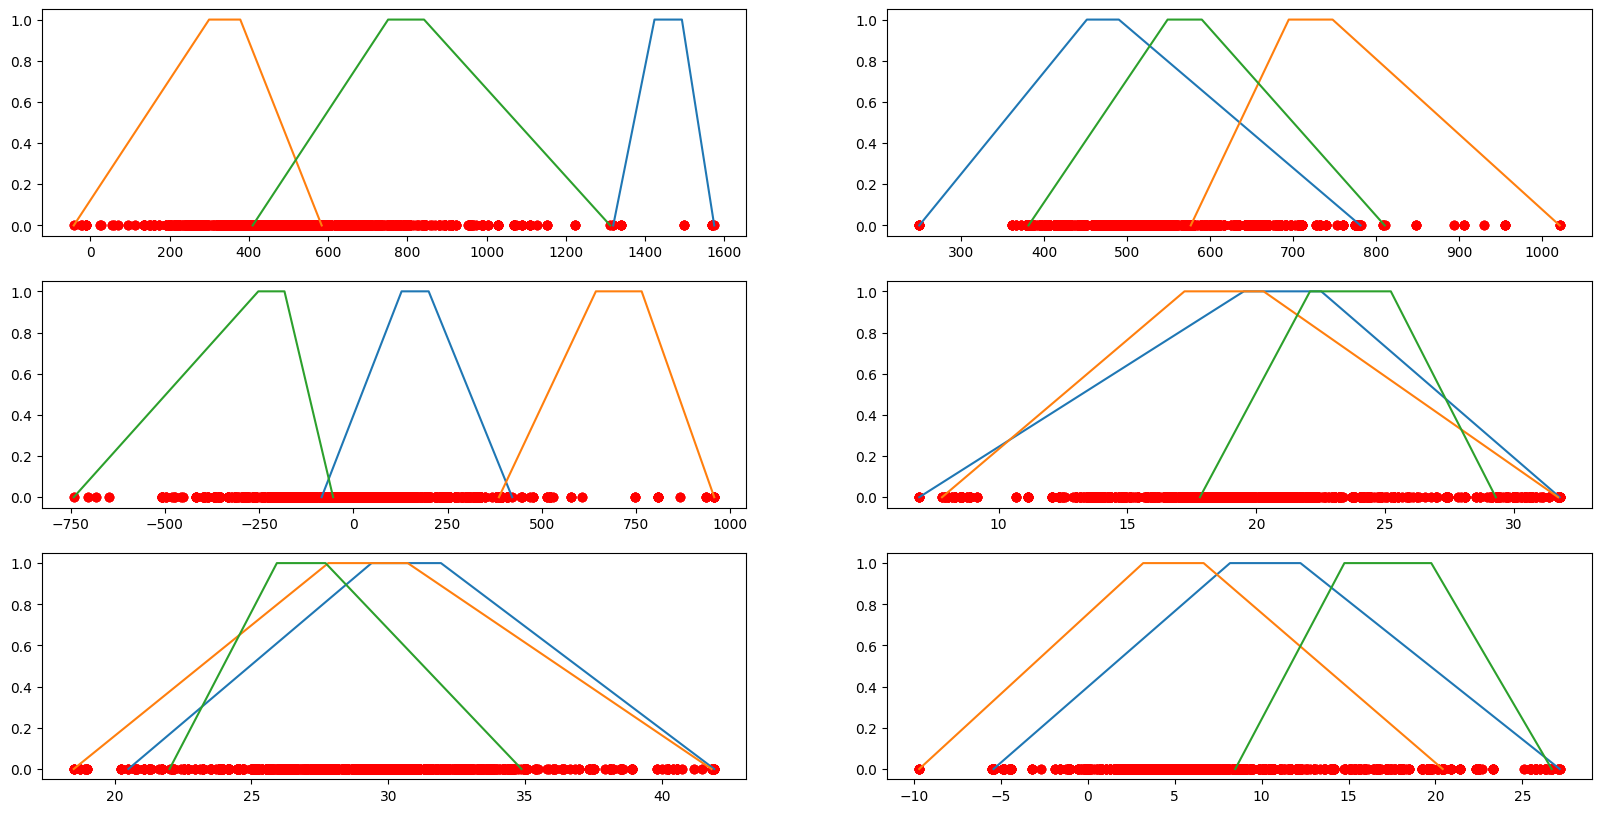

In [554]:
fig, ax = plt.subplots(3,2, figsize=(20, 10))
for plot in range(0,6):
    for mf in mfs[plot]:
        ax[int(plot / 2)][plot % 2].plot(mf, [0,1,1,0])
        ax[int(plot / 2)][plot % 2].scatter(merged_data.iloc[:, plot+1], np.zeros(merged_data.shape[0]), c="r")

plt.show()

In [555]:
feature_sets

[array([1458.075     ,  338.88821584,  796.66913986]),
 array([470.77457121, 721.03721657, 569.35326346]),
 array([ 163.91630036,  704.12102083, -217.37975143]),
 array([21.01995789, 18.74888844, 23.65555583]),
 array([30.6580786 , 29.26108214, 26.81785127]),
 array([10.20625408,  4.92492415, 17.2589125 ])]

In [556]:
clusters

{0: [1, 0, 2, 1, 1, 1],
 1: [2, 0, 0, 0, 0, 0],
 2: [1, 2, 2, 1, 1, 1],
 3: [2, 0, 1, 0, 0, 0],
 4: [2, 2, 0, 0, 1, 0],
 5: [1, 2, 2, 1, 0, 1],
 6: [1, 0, 0, 0, 0, 0],
 7: [0, 2, 1, 2, 1, 2],
 8: [2, 1, 0, 1, 2, 0],
 9: [2, 1, 2, 1, 1, 0]}

In [ ]:
test_mfs = cluster_fit.cluster_centers_[:,0].reshape(-1, 1)
np.concatenate((test_mfs, np.unique(cluster_fit.labels_).reshape(-1, 1)), axis=1)

array([[ 0.05590238,  0.        ],
       [ 0.05971854,  1.        ],
       [-0.02858077,  2.        ],
       [-0.05023716,  3.        ],
       [ 0.10431807,  4.        ],
       [ 0.10864697,  5.        ],
       [-0.055525  ,  6.        ],
       [ 0.02489804,  7.        ],
       [-0.05946952,  8.        ],
       [-0.00970909,  9.        ]])

Here the consequents are calculated by LinearRegression

In [ ]:
subclusters = merged_data["Subcluster_number"].unique()
r2_scores = []
consequent_params = []
intercepts = []
for subcluster in subclusters:
    cur_X = merged_data[merged_data["Subcluster_number"] == subcluster].iloc[:, 1:-1]
    cur_Y = merged_data[merged_data["Subcluster_number"] == subcluster].iloc[:, 0]
    cur_linear = LinearRegression().fit(cur_X, cur_Y)
    consequent_params.append(cur_linear.coef_)
    intercepts.append(cur_linear.intercept_)
    r2_scores.append(cur_linear.score(cur_X, cur_Y))


In [ ]:
r2_scores

[0.12209126306304219,
 0.15050735345837174,
 0.14309397207991392,
 0.1218633350362065,
 0.3844126841594627,
 0.1289081188788641,
 0.22480043529643612,
 0.22314155858016826,
 0.4729514384487973,
 0.6628534514428013]

In [ ]:
consequent_params

[array([-8.38238961e+02,  8.38240310e+02,  8.38239826e+02,  5.16253581e-02,
        -3.98112182e-02, -6.45572536e-03]),
 array([ 0.00106686,  0.00201163, -0.00094477,  0.0433082 ,  0.00954507,
        -0.01512306]),
 array([-6.34110375e+01,  6.34108771e+01,  6.34110586e+01, -1.25705349e-02,
         2.86598900e-02,  6.61287376e-04]),
 array([ 6.41941302e+01, -6.41934384e+01, -6.41944920e+01, -4.51076247e-02,
         6.18753077e-02,  6.49036415e-03]),
 array([ 2.97159810e+02, -2.97160446e+02, -2.97160014e+02,  5.63881580e-02,
        -6.69250976e-02, -7.24021804e-03]),
 array([-1.42449633e+03,  1.42449471e+03,  1.42449147e+03,  9.16777816e-02,
        -3.83707403e-02, -5.78797869e-02]),
 array([ 5.78653899e+01, -5.78661884e+01, -5.78668389e+01,  5.92515088e-02,
        -3.61072515e-03, -2.02924223e-02]),
 array([-3.05404167e+01,  3.05402946e+01,  3.05400758e+01, -1.03590872e-02,
         2.25984101e-02, -3.62938315e-03]),
 array([-8.89836152e+02,  8.89837624e+02,  8.89835249e+02, -1.30

Prepare the mf representation

In [597]:
rows = []
feature_names = merged_data.iloc[:, 1:-1].columns
for i, feature in enumerate(mfs):
    for j, mf in enumerate(feature):
        rows.append([i, feature_names[i], j, mf[0], mf[1], mf[2], mf[3]])

fuzzy_set_table = pd.DataFrame(rows, columns=["feature_id", "feature_name", "set_id", "a", "b", "c", "d"])


In [598]:
rows = []
for rule_number, rule in clusters.items():
    rows.append(np.concatenate((rule, consequent_params[rule_number], [intercepts[rule_number]], [r2_scores[rule_number]])))

rule_base = pd.DataFrame(rows, columns=np.concatenate((feature_names, ["p"+str(i) for i in range(len(feature_names))], ["r"], ["r2"])))

In [599]:
rule_base

,P,E,PB,Tave,Tmax,Tmin,p0,p1,p2,p3,p4,p5,r,r2
0,1.0,0.0,2.0,1.0,1.0,1.0,-838.238961,838.240310,838.239826,0.051625,-0.039811,-0.006456,-0.627382,0.122091
1,2.0,0.0,0.0,0.0,0.0,0.0,0.001067,0.002012,-0.000945,0.043308,0.009545,-0.015123,-2.696434,0.150507
2,1.0,2.0,2.0,1.0,1.0,1.0,-63.411038,63.410877,63.411059,-0.012571,0.028660,0.000661,-0.589020,0.143094
3,2.0,0.0,1.0,0.0,0.0,0.0,64.194130,-64.193438,-64.194492,-0.045108,0.061875,0.006490,-1.432732,0.121863
4,2.0,2.0,0.0,0.0,1.0,0.0,297.159810,-297.160446,-297.160014,0.056388,-0.066925,-0.007240,1.288163,0.384413
5,1.0,2.0,2.0,1.0,0.0,1.0,-1424.496332,1424.494705,1424.491468,0.091678,-0.038371,-0.057880,0.568804,0.128908
6,1.0,0.0,0.0,0.0,0.0,0.0,57.865390,-57.866188,-57.866839,0.059252,-0.003611,-0.020292,-0.245156,0.224800
7,0.0,2.0,1.0,2.0,1.0,2.0,-30.540417,30.540295,30.540076,-0.010359,0.022598,-0.003629,-0.428554,0.223142
8,2.0,1.0,0.0,1.0,2.0,0.0,-889.836152,889.837624,889.835249,-0.130624,0.007427,0.091817,1.360816,0.472951
9,2.0,1.0,2.0,1.0,1.0,0.0,-0.001633,-0.000471,-0.001175,0.028663,-0.040686,-0.004849,4.251617,0.662853
